# create 3D maps of prisms with objective / neutral perspective
(location / distance to origin does not matter for size of objects)


## Approach with polygons split to convex shapes
### methods to rely on:
- split polygons to convex shapes
- store convex polys and height in array of objects
- save to object which vertices belong to original objects outline with their indexes to later retain edges of the prisms 
- if opacity of wall color will be alpha=1 then filter out vertices that are not visible anyways:
    - they are not visible if: they the highest point is above line connecting most left and right outwards points
- and to each object add the distance of its closest point to perspective origin
- sort array of objects descending according to that distance measure
- start plotting along the sorted array:
    - plot wall that did belong to original outline
        - color potentially based on orientation 
        - if outline: give border to all walls 
    - plot roof
        - (potentially include a check whether roof is visible at all in the end)
        - fill with color
        - if outline: plot edges that belonged to orignal outline
    - (potentially add shadow along roof and wall in a later stage)
    
### (optional) functionalities:
- plot edges
- plot alpha
- plot fill with pattern
- size objects based on distance
- use non parallel perspective
- change angle (up, down)

### assumptions on inputs
- valid polygons
- non-overlapping

### improve:
- split polygon to convex shapes: try to create fewer shapes. 
- add edges to roofs




### libraries

In [480]:
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString, Point, MultiPolygon, GeometryCollection
from shapely.affinity import translate, scale
from shapely.ops import unary_union
from geopandas import GeoDataFrame, GeoSeries, read_file
import numpy as np
from numpy import sign
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime
import os

### function imports:

In [481]:
def angleToNorth (point_base:tuple = (0,0), point_end:tuple = (0,0)):
    """
    point_base and point_end each must be a tuple of point coords eg. (0,1)
    return angle to north ((0,0) to (0,1))
    """
    xDiff, yDiff = point_end[0] - point_base[0], point_end[1] - point_base[1]
    
    if(xDiff == 0):
        angle = 0 if(yDiff > 0) else 180
    else:
        angle = -math.atan(yDiff / xDiff) * 180 / math.pi + (270 if(xDiff<0) else 90)
    
    return angle

In [483]:
def definedClockwise (coords:list)->bool:
    """
    returns whether coords that define 2D-shape are defined (mostly) clockwise
    """
    
    return sum([(c1[0]-c0[0])*(c1[1]+c0[1]) for c0,c1 in zip(coords, coords[1:]+coords[:1])])>0

In [484]:
def noDoubleCoords (coords:list)->list:
    """
    Function that clean coordinates such a coordinate that directly follows itself is removed
    """
    return [c0 for c0,c1 in zip(coords, coords[1:]+coords[:1]) if not c0 == c1]

In [485]:
def inclusiveSplit (l:list, i:int, j:int, both:bool=True):
    """
    if both not true it will only return the part in between i and j
    comments below show logic. code is more compact
    """
    
    if both:
        return \
            [\
            (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i<=j else (l[max(i,j):] +l[:min(i,j)+1]), 
            (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i>j else (l[max(i,j):] +l[:min(i,j)+1])\
            ]
    
    if i<=j:
        return (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i<=j else (l[max(i,j):] +l[:min(i,j)+1])
        
    return (l[min(i,j) : max(i,j)+1] + ([] if (max(i,j)<len(l)) else [l[0]])) if i>j else (l[max(i,j):] +l[:min(i,j)+1])
    
# x, y = min(i,j), max(i,j)
# partA = l[x : y+1] + ([] if (y<len(l)) else [l[0]])
# partB = l[y:] +l[:x+1]
# if i<=j:
#     part1 = partA
#     part2 = partB
# else:
#     part1 = partB
#     part2 = partA
# if both:
#     return [part1, part2]
# else:
#     return part1

In [486]:
from math import copysign

def return_sign(n):
    """
    function calling copysign from math module but return 0.0 for n == 0 instead of 1.0
    """
    if n == 0:
        return 0.0
    return copysign(1,n)

def halfspaceSide (point:tuple, vectorEnd:tuple, vectorBase:tuple=(0,0)) -> int:
    """
    check whether point is on left or right side of vector or on vector

    """
    return \
        return_sign(\
        (point[0]-vectorBase[0])*(vectorEnd[1]-vectorBase[1]) - \
        (point[1]-vectorBase[1])*(vectorEnd[0]-vectorBase[0])\
        )

In [487]:
def relationToHalfspace (point:tuple, vectorEnd:tuple, vectorBase:tuple=(0,0)) -> int:
    """
    check whether point is on left (return < 0) or right (return > 0) side of vector or on exactly vector (returns 0)

    """
    return \
        (point[0]-vectorBase[0])*(vectorEnd[1]-vectorBase[1]) - \
        (point[1]-vectorBase[1])*(vectorEnd[0]-vectorBase[0])
        

In [488]:
def allConvexCoords (coords, counterClockwise:bool=True) -> list:
    """
    Function that return list of all indexes of coordinates that are convex
    Convex means that the coordinate would lie inside the polygon if the polygon would be defined s.t. the previus coordinate would be directly connected to the following coordinate
    Inputs: 
    - coords: coordinate array forming a polygon, (!) defined counter-clockwise if not specified otherwise (!)
    """
    l = len(coords)
    if l < 4:
        return []
    
    return [i for (i, c0,c1,c2) \
        in zip(range(l), coords[-1:]+coords[:-1], coords, coords[1:] + coords[:1]) \
        if (c1[0]-c0[0])*(c2[1]-c0[1]) - (c1[1]-c0[1])*(c2[0]-c0[0]) < 0]
   

In [489]:
def shiftArray(arr, shift=0):
    """
    Fast method to shift array
    # Inputs:
    - arr: array
    - shift: number of elements that the array should be shifted to the back if >0 elements from back get shifted to front
    """
    return arr[-shift:]+arr[0:-shift]

In [490]:
def isConvex(coords:list)->bool:
    """
    Function that return whether coordinate ring is convex
    # Inputs:
    - coords: list of coordinate tuples defined counter clockwise
    """

    if len(coords) < 4:
        return True
    
    for c0, c1, c2 in zip(coords[-1:]+coords[:-1], coords, coords[1:] + coords[:1]):
        if (c1[0]-c0[0])*(c2[1]-c0[1]) - (c1[1]-c0[1])*(c2[0]-c0[0]) < 0:
            return False

    return True

In [491]:
r = [zip(coords[-1:]+coords[:-1], coords, coords[1:] + coords[:1]) and False for coords in extCoords]

In [573]:
def toggleMetersToDegrees (coord:tuple=(0,0), lat:float=52.5, outputUnit=["meters", "degrees"][1]):
    """
    transform meters to degrees and vice versa
    """
    # s
    #theta is the latitude in degrees 
    r_earth, theta = 6378, lat #*1000
    #The number of kilometers per degree of longitude is approximately
    #The number of kilometers per degree of latitude is approximately the same at all locations, approx
    lonkm, latkm = (math.pi/180) * r_earth * math.cos(theta*math.pi/180), (math.pi/180) * r_earth

    projection_rescale = (coord[0]/(lonkm*1000), coord[1]/(latkm*1000)) if outputUnit in "degrees" else (coord[0]*(lonkm*1000), coord[1]*(latkm*1000))

    return projection_rescale

In [ ]:
def addSelfIntersectingCoords(coords) -> list:
    """
    Function adds self-intersecting coordiates for invalid coordinate rings and returns coordinate list
    If a ring would cross itself the intersection coordinates are added at the correct place in array
    
    ## Inputs:
    - coords = list of coordinates
    """
    edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
    # 2do check that sorted sorts in correct order
    coordsWithIntersectionPoints = \
        [item for sublist in [[coords[i]]+\
        [item for sublist in \
        [sorted(list(edges[i].intersection(edges[j]).coords),\
        key=lambda intersec: abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
        for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
        for item in sublist] \
        for i in range(len(coords)-1)] \
        for item in sublist]
    # print("coordsWithIntersectionPoints",coordsWithIntersectionPoints)
    return coordsWithIntersectionPoints

In [494]:
def cutPolygonAtProblematicPoints ( poly:Polygon ) -> list:
    """
    Function that divides polyons at points where they are self intersecting returning list of Polygons
    """
    coords = noDoubleCoords(poly.exterior.coords)
    
    # set up list of indexes of problematic coordiantes
    pc = [i for i,p in enumerate(coords) if coords.count(p)>1]

    if len(pc) == 0:
        return [Polygon(coords)]
    i, it = 0, 0
    while i < len(pc) and it<len(pc)*len(pc)*len(coords):
        j = i+1
        while j < len(pc):
            k = 1
            while k < pc[i+1]-pc[i]:
                m = 1
                while m < ( (pc[j+1]-pc[j]) if j+1<len(pc) else len(coords)-1-pc[j]+pc[0] ):
                    if coords[pc[i] + k] == coords[(pc[j] + m)%len(coords)]:
                        m += 1
                        continue

                    line = LineString([coords[pc[i] + k], coords[(pc[j] + m)%len(coords)]])
                    # check if this crosses any other edge
                    
                    if poly.contains(line):
                        newCoords = inclusiveSplit(coords, pc[i] + k, (pc[j] + m)%len(coords) )
                        listOfPolys = [Polygon(c) for c in newCoords]
                        listOfPolys = [item for sublist in [[p] if p.is_valid else cutPolygonAtProblematicPoints(p) for p in listOfPolys] for item in sublist]
                        return listOfPolys
                    m += 1
                    it += 1
                k += 1
            j += 1
        i+=1
    
    newCoords = inclusiveSplit(coords, pc[-1], coords.index(coords[pc[-1]]))
    listOfPolys = [Polygon(c) for c in newCoords]
    listOfPolys = [item for sublist in [[p] if p.is_valid else cutPolygonAtProblematicPoints(p) for p in listOfPolys] for item in sublist]
    return listOfPolys


            

In [495]:
# 2do create a function that make invalid polygons valid
def makePolygonValid (poly:Polygon) -> list:
    """
    return polygon as list of valid polygons
    if one wants to make absolutely sure that resulting polygons are valid, one shall splitAtInteriors before 
    (because touching interiors are invalid no matter how you define them) 
    """
    interiors = []
    for interior in poly.interiors:
        interiorCoords = list(interior.coords)
        if interior.is_valid:
            if not definedClockwise(interiorCoords):
                interiorCoords.reverse()
            interiors.append(interiorCoords)
        else:
            listOfInteriorPolys = cutPolygonAtProblematicPoints(Polygon(addSelfIntersectingCoords(interiorCoords)))
            for interiorPoly in listOfInteriorPolys:
                splittedInterior = list(interiorPoly.exterior.coords)
                if not definedClockwise(splittedInterior):
                    splittedInterior.reverse()
                interiors.append(splittedInterior)
    #

    coords = addSelfIntersectingCoords(poly.exterior.coords)
    newPoly = Polygon(coords, interiors)
    if newPoly.is_valid:
        return [newPoly]
    polys = cutPolygonAtProblematicPoints(newPoly)
    # print("are valid??", [x.is_valid for x in polys])
    return polys

In [496]:
# in some (extremly rare) situations like sdf id 267682, 348472, 379995 it removed an interior
# and 28 polygons with interiors havent been resolved successfully

def splitAtInteriors (poly:Polygon, plot=False) -> list:
    """
    convert any polygon to array of polygons that do not cotaining any interiors
    
    All coord rings are made counter-clockwise

    Assumption: 
    for each polygon with interiors there exist an interior with points j and j0 for j != j0
    that you can connect with a valid line from to j the exterior point k and from j0 to k0 for k != k0

    """
    interiors = poly.interiors
    

    # early return if no interiors
    if len(interiors) == 0:
        return [poly]

    polyExterior = poly.exterior
    extCoords = noDoubleCoords(polyExterior.coords)
    
    if not poly.is_valid:
        interiors = \
            [item for sublist in \
                [\
                    [interior] \
                    if interior.is_valid else \
                    [s.exterior \
                        for s in cutPolygonAtProblematicPoints(\
                            Polygon(addSelfIntersectingCoords(list(interior.coords)))\
                        )\
                    ] \
                    for interior in interiors\
                ] \
            for item in sublist]
    #
    interiorsCoords = [noDoubleCoords(interior.coords) for interior in interiors]
    
    if definedClockwise(extCoords):
        extCoords.reverse()
                        
    i = 0
    while i < len(interiors):
        if not definedClockwise(interiorsCoords[i]):
            interiorsCoords[i].reverse()
        # store here the indices j0/j at which interior shall be split and k0/k to split exterior
        j, j0, k0, line0 = 0, -1, -1, -1
        
        # stop trying for interior i as soon as you can't connect two seperate coordinates to exterior 
        while j < len(interiorsCoords[i]) - (k0 == -1):
            k = 0
            while k < len(extCoords) and not j == j0:
                
                line = LineString([interiorsCoords[i][j], extCoords[k]])
                
                # perform multiple checks whether line from interior to exterior shall be chosen
                # line.intersects(edge) and not line.touches(edge) handles case where line partly overlays with edge but doesn't cross
                if \
                    k != k0 \
                    and poly.contains(line) \
                    and not (k0 != -1 and (line.intersects(line0) or line.touches(line0)) )\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([interiorsCoords[i][n], interiorsCoords[i][(n+1)%len(interiorsCoords[i])]]) for n in range(len(interiorsCoords[i]))]])\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([extCoords[n], extCoords[n+1]]) for n in range(len(extCoords)-1)]]):
                    
                    if k0 == -1:
                        j0, k0, line0 = j, k, line
                        # reset k index such that it will start with 0 in next iteration
                        k = 0
                        continue
                    
                    else:
                        # divide polygon into two parts A and B
                        intA = interiorsCoords[i][j0:j+1]
                        intB = interiorsCoords[i][j:] + interiorsCoords[i][:j0+1]
                        extA = (extCoords[k:] + extCoords[:k0+1]) if k0<k else extCoords[k:k0+1]
                        extB = (extCoords[k0:] + extCoords[:k+1]) if k0>k else extCoords[k0:k+1]

                        polyCoords = [extA + intA, extB + intB ]
                        polygons = [Polygon(coords) for coords in polyCoords]
                        
                        if(plot):
                            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                            GeoSeries(polygons).plot(ax=ax, alpha=0.4, cmap="viridis", edgecolor="black")
                            GeoSeries([Point(interiorsCoords[i][j]), Point(interiorsCoords[i][j0]) ]).plot(ax=ax, cmap="tab10", linewidth=3)
                            GeoSeries([Point(extCoords[k]), Point(extCoords[k0]) ]).plot(ax=ax, cmap="tab10", linewidth=3)
                            GeoSeries([line, line0]).plot(ax=ax, cmap="tab10", linewidth=3)
                            for x, y, label in zip([extCoords[x][0] for x in range(len(extCoords))], [extCoords[x][1] for x in range(len(extCoords))], [str(x) for x in range(len(extCoords))]):
                                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                            for x, y, label in zip([interiorsCoords[i][x][0] for x in range(len(interiorsCoords[i]))], [interiorsCoords[i][x][1] for x in range(len(interiorsCoords[i]))], [str(x) for x in range(len(interiorsCoords[i]))]):
                                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                        
                        # early return if just one interior
                        if len(interiors) == 1:
                            return polygons
                        
                        #else check where to nest further
                        polygons = [Polygon(coords,[interiors[n] for n in range(len(interiors)) if not n == i and Polygon(coords).contains(interiors[n])]) for coords in polyCoords]
                        polygons = [item for sublist in [[ply] if len(ply.interiors) == 0 else splitAtInteriors(ply,plot=plot) for ply in polygons] for item in sublist]
                        return polygons
                k += 1
            j += 1
        i += 1
    #

In [532]:
def splitToConvex(poly:Polygon, plot:bool=False, it=0) -> list:
    """
    Function recursively splits a polygon (valid, without interiors) into two parts until the initial polygon is completly divided into convex shapes
    it returns a list of triangle coordinates
    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    lvl indicates the deepness of the nest
    """
    if it > 1000:
        raise KeyError("splitToConvex exceed max iterations. Check if coorect input was given.", noDoubleCoords(poly.exterior.coords)) 
    # 2Do future improvement: noDoubleCoords might slow funtion down
    coords = noDoubleCoords(poly.exterior.coords)
    
    if len(set(coords))<4:#2do remove set operation?
        return [coords]
    
    if definedClockwise(coords):
        coords = coords[::-1]
    
    convexCoords = allConvexCoords(coords)
    
    
    if(plot):
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
        GeoSeries([poly]).plot(ax=ax, color = "pink")
        GeoSeries([Point(coords[x]) for x in convexCoords]).plot(ax=ax, alpha=0.9, color = "red", linewidth=2)
        for x, y, label in zip([coords[x][0] for x in range(len(coords))], [coords[x][1] for x in range(len(coords))], [str(x) for x in range(len(coords))]):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points ")
        #
    
    if len(convexCoords) == 0:
        
        return [coords]
    
    if  len(convexCoords) == 1:
        
        # if only one convex point, convextiy can be removed in one iteration
        i = convexCoords[0]
        coord_pre, coord_i, coord_post = coords[(i-1)%len(coords)], coords[i], coords[(i+1)%len(coords)]
        # to remove convexity connect it to coordinate j 
        #   that is not i or a direct neighbour of i
        #   that is left of both halfspaces: from i-1 to i and from i to i+1
        combinations = [(i, 
            next((
                j for j, coord_j in zip(range(len(coords)), coords) if \
                j not in [(i-1)%len(coords), i, (i+1)%len(coords)] and \
                relationToHalfspace(coord_j, coord_post, coord_i) <=0 and \
                relationToHalfspace(coord_j, coord_i, coord_pre) <= 0
                ),
                (i+2)%len(coords))
            )]
    else:
        # potential improvement here: this section as is does not split to the lowest possible number of polygons
        # check if there is a gap within convexCoords
        singleConvexCoords = [x for x in convexCoords if not (x-1)%len(coords) in convexCoords and not (x+1)%len(coords) in convexCoords ]
        if len(singleConvexCoords) == 0:
            i = next(x for x in convexCoords if not x+1 in convexCoords)
            
            combinations = [item for sublist in [[(i, convexCoords[k]) for k in range(n+2,len(convexCoords))] for n,i in enumerate(convexCoords)] for item in sublist] +\
                [(i, convexCoords[(n+2)%len(convexCoords)]) for n, i in enumerate(convexCoords)] +\
                [(i, (i+2)%len(coords)) for i in convexCoords if not (i+2)%len(coords) in convexCoords]
            
        else:
            # first try all combination between i and i+1, because this would create a convex area
            # then between i and the remaining (which does not directly remove a convex area)
            combinations = [(i, convexCoords[(n+1)%len(convexCoords)]) for n,i in enumerate(convexCoords)] +\
                [item for sublist in [[(i, convexCoords[k]) for k in range(n+2,len(convexCoords))] for n,i in enumerate(convexCoords)] for item in sublist]
    #
    
    for i,j in combinations:
        line = LineString([coords[i],coords[j]])
        
        if poly.contains(line):
            splitted = inclusiveSplit(coords, i, j)
            if(plot):
                fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
                GeoSeries([poly]).plot(ax=ax, color = "pink")
                GeoSeries([Polygon(x) for x in splitted]).plot(ax=ax, alpha=0.6, cmap = "viridis", edgecolor="black")
                # print(it,"inclusiveSplit", inclusiveSplit(list(range(len(coords))), i, j))
                GeoSeries([line]).plot(ax=ax, alpha=0.9, color = "black", linewidth=4)
                for x, y, label in zip([coords[x][0] for x in range(len(coords))], [coords[x][1] for x in range(len(coords))], [str(x) for x in range(len(coords))]):
                    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points ")
            
            return [item for sublist in [splitToConvex(Polygon(splt), plot=plot, it=it+1) for splt in splitted] for item in sublist]
    
    # raise KeyError("triangularize did not return anything. Check if coorect input was given.", i, j, coords)
    print("splitToConvex did not return anything. Check if coorect input was given.", i, j, coords)
    print("combinations", combinations)
    if(True):
                fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
                GeoSeries([poly]).plot(ax=ax, color = "pink")
                GeoSeries([line]).plot(ax=ax, alpha=0.9, color = "black", linewidth=4)
                for x, y, label in zip([coords[x][0] for x in range(len(coords))], [coords[x][1] for x in range(len(coords))], [str(x) for x in range(len(coords))]):
                    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points ")
    return [coords]
    #
#
    #
#

In [559]:
def projectConvexShadow (coords:shapely.coords.CoordinateSequence or list, v:tuple)->Polygon:
    """
    Inputs:
    coords = list of coordinates (tuples)
    v = tuple indicating a vector from origion (0,0) to point(vector)
    returns Polygon(shadowCoords) 
    Idea: 
    A triangle that is projected a long a vector of positive length is alwas transformed into a pentagon
    which consits of all points of orignal triangle and points of triangle shifted with vector 
    excluding one point (the one not left or rightmost in angle direction) from origanal triangle
    if that point is most fast towards vector direction out of the three points of that orig triangle
    else exclude that point from the shifted triangle
    """

    coords = noDoubleCoords(coords)
    
    if definedClockwise:
        coords = coords[::-1]

    if not len(coords) > 2:
        raise ValueError("coords provided to triangle project projectConvexShadow are not of length >2:",len(coords), coords)

    # check how far the coordinates are left or right of base vector 
    offsetOrthogonal = [(coords[i][0])*(v[1])-(coords[i][1])*(v[0]) for i in range(len(coords))]
    minI = offsetOrthogonal.index(min(offsetOrthogonal))
    maxI = offsetOrthogonal.index(max(offsetOrthogonal))
    
    coordsSplitted = inclusiveSplit(coords, maxI, minI)

    return Polygon(coordsSplitted[0] + [(coord[0]+v[0], coord[1]+v[1]) for coord in coordsSplitted[1]])


In [499]:
def getConvexCoords (poly:Polygon, triangleMethod:bool=True, checkIfConvex:bool=False, plot:bool=False)->list:
    """
    Function that combines all methods to divide any polygon into convex polygons and return their coordinates
    """
    # 2do validate polygon in the first step
    if not plot:
        if poly.is_valid:
            return \
                [item for sublist in \
                    [splitToConvex(splt, plot=plot) for splt in splitAtInteriors(poly)] \
                for item in sublist]
        else:
            return \
                [item for sublist in \
                    [splitToConvex(splt, plot=plot) for splt in \
                        [item for sublist in \
                            [makePolygonValid(spltToValidate) for spltToValidate in splitAtInteriors(poly)]\
                        for item in sublist]] \
                for item in sublist]

    #

    
    if poly.is_valid:
        splitted = splitAtInteriors(poly, plot=False)
    else: 
        splitted = [item for sublist in [makePolygonValid(spltToValidate) for spltToValidate in splitAtInteriors(poly)] for item in sublist]
    
    listOfConvexCoords = [item for sublist in [splitToConvex(splt, plot=False) for splt in splitted] for item in sublist]
        
    
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (24,6))
    GeoSeries([poly]).plot(ax=ax.flat[0], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=ax.flat[1], color = "pink", edgecolor="black", linewidth=3)
    GeoSeries([poly]).plot(ax=ax.flat[2], color = "white", edgecolor="black", linewidth=3)
    GeoSeries(splitted).plot(ax=ax.flat[2], cmap="viridis",edgecolor="black")
    GeoSeries([poly]).plot(ax=ax.flat[3], color = "white", edgecolor="black", linewidth=3)
    convexPolys = [Polygon(cc) for cc in listOfConvexCoords]
    GeoSeries(convexPolys).plot(ax=ax.flat[3], cmap="viridis",edgecolor="black")
    
    return listOfConvexCoords

In [500]:
def makeCounterClockWise(arr, bl:bool=True):
    """"
    set bl = True if it should be counterclockwise else it will be made clockwise
    """
    if bl==definedClockwise(arr):
        arr = arr[::-1]
    if not arr[0] == arr[-1]:
        arr = arr + [arr[0]]
    return arr

# Load gdf

In [501]:
gdf = read_file('./input_data/Gebaeude_Hoehen_Phase1.shp')
gdf.to_crs(4326, inplace=True)

<AxesSubplot:>

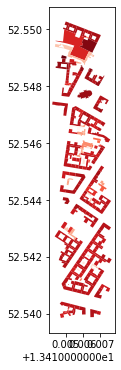

In [691]:
# select area of interest
gdfcx = gdf
# Region 1
gdfcx = gdf.cx[13.40005 : 13.407602, 52.5335 : 52.53682] # region 1
# gdfcx = gdf.cx[13.4023 : 13.40231, 52.53485 : 52.535]
# gdfcx = gdf.cx[13.4024 : 13.403, 52.53495 : 52.5351]
# gdfcx = gdf.cx[13.401951 : 13.4020, 52.5354 : 52.5357][0:1]
# gdfcx = gdf.cx[13.4024 : 13.403, 52.53485 : 52.535][:1]

# Region 2
# gdfcx = gdf.cx[13.41005 : 13.412102, 52.5445 : 52.54682] # region 2
# gdfcx = gdf.cx[13.4119 : 13.412102, 52.5462 : 52.5465]
# gdfcx = gdf.cx[13.4119 : 13.412102, 52.5462 : 52.5465][1:]

# Region 3
# gdfcx = gdf.cx[13.415 : 13.425, 52.54 : 52.55] # region 3
gdfcx = gdf.cx[13.415 : 13.416, 52.54 : 52.55] # region 3
# gdfcx = gdf.cx[13.415 : 13.416, 52.547 : 52.5482]


gdfcx = gdfcx.rename({'OBJECTID': 'id', 'Mean_nDOM': 'height'}, axis='columns')
gdfcx.drop([x for x in gdfcx.columns if x not in ['id', 'height', 'geometry']], axis=1, inplace=True)
gdf_prep = gdfcx
gdf_prep.plot(figsize=(10,6), column='height', cmap='Reds')#, edgecolor='black', linewidth=10/len(gdf_prep)

# Create function:

## Set parameters:

In [692]:

# Parameters for plotting:  
# Parameters affecting sorting:
relative_perspective = False
point_of_view = (0,-1,1)
remove_shared_walls = True
shared_walls_tolerance = 1e-8

plot_top_layer_only = False

# Parameters not affecting sorting:
azimuth = 265 # angle clockwise to north
border_to_polygon_buffer = 1e-7*1 # 2Do think about drawing the border only at corners where there is a visible angle in orig shape
buff_resolution = 3 # the smaller the lower the resolution minimum = 0
keep_only_original_geometries = True


meter_factor_x, meter_factor_y = toggleMetersToDegrees((0,1))



## Create 2D Projections of 3D shapes

In [693]:
def get_outward_coords(ccs, first:bool=True, relative_perspective:bool=relative_perspective, point_of_view:tuple=point_of_view)->tuple:
    """
    function return most outward (most to left or most to right) coordinate of list of coordinates
    Inputs:
    - list of coordinate tuples
    - first: True if your looking for the first (most left) coordinate or False for last (most right) coordinate
    - relativePerspective: whether 
    """

    if not relative_perspective:
        if first:
            return [min(cc) for cc in ccs]
        return [max(cc) for cc in ccs]

    # if relativePerspective calculate angles between each coordinates and point of view
    x,y = point_of_view[0], point_of_view[1]
    angles = [(cc,(x,y)) for cc in ccs]

    return 


def wall_facing_view(c0:tuple, c1:tuple, relative_perspective:bool=relative_perspective, point_of_view:tuple=point_of_view) -> bool:
    """
    Return true if the wall might be visible from the point of view as an outside wall or if only visible through other objects else false
    Inputs:
    - c0, c1 coordinate tuples taken in the order of apperance (=counter clockwise) in list of coordinates of shapes 
    """

    if not relative_perspective:
        return angleToNorth(c0, c1) < 180

    # if relativePerspective calculate angles between each coordinates and point of view
    x,y = point_of_view[0], point_of_view[1]

    return 
    


In [694]:
# make sure geometries are defined correctly
gdf_prep = gdf_prep[[type(g)==Polygon for g in gdf_prep.geometry]]
gdf_prep['geometry'] = [Polygon(makeCounterClockWise(g.exterior.coords, True), [makeCounterClockWise(i.coords, False) for i in g.interiors]) for g in gdf_prep['geometry']]

maxCoordLen = len(str(\
    max([len(g.exterior.coords) + sum([len(i.coords[::-1]) for i in g.interiors]) for g in gdf_prep.geometry])\
    ))

# Precision issue
"""
precision issue: 
- a precision of float numbers is limited to a certain number of digits it can in some cases not be determined if a point lies on a line or not
- 
"""
# sys.float_info.dig
from sys import float_info
precision_fix = 1.0 * 10**(float_info.dig)
precision_tolerance = 1.0 * 10**(float_info.dig*-1)

In [695]:
# split original polygons to convex shapes, project walls and roofs for original footprints and save information
# bounded_from serves as a tie breaker. if two shapes have same left_xy and right_xy then the one that has points above line from left_xy to right_xy is more in background

shape_arr = [item for sublist in [item for sublist in [
        [
            [[{
                'role': 'footprint',
                'geometry': Polygon(cc), 
                'height': h,
                'left_x': left_x,
                'left_y': left_y,
                'right_x': right_x,
                'right_y': right_y,
                'bounded_from': next((halfspaceSide(c, (left_x, left_y), (right_x, right_y)) for c in cc if halfspaceSide(c, (left_x, left_y), (right_x, right_y)) != 0), 0),
                'slope': (right_y-left_y)*precision_fix/(right_x-left_x) if right_x!=left_x else math.inf,
                'intercept': ((right_y-left_y)*precision_fix/(right_x-left_x) if right_x!=left_x else math.inf)*-left_x+left_y*precision_fix,
                'g_id': g_id,
                'footprint_id': footprint_id,
                'self_id': footprint_id,
                'valid': True
            }] + 
            [{
                'role': 'roof',
                'geometry': Polygon([(x,y+meter_factor_y*h) for x,y in cc]),
                'height': h,
                'g_id': g_id,
                'footprint_id': footprint_id,
                'self_id': footprint_id + 1,
                'valid': True
            }] + 
            [x for x in [{
                'role': 'wall',
                'geometry': Polygon([c0, c1, (c1[0], c1[1]+meter_factor_y*h), (c0[0], c0[1]+meter_factor_y*h)]),
                'c0': c0,
                'c1': c1,
                'min_offset': min([x*0+y*1 for (x,y) in [c0,c1]]),
                'height': h,
                'g_id': g_id,
                'footprint_id': footprint_id,
                'self_id': footprint_id + n_*10+2,
                'orientation': abs(azimuth - (angleToNorth(c0, c1)-90)%360)/360, # orientation towards the sun from 0 to 100
                'facing_view': wall_facing_view(c0,c1), # whether the wall is facing point of view or whether it only might be visible throug other walls / roofs
                'valid': any([
                        c0 in og_c_arr and c1 in og_c_arr and 
                        (og_c_arr.index(c1)==(og_c_arr.index(c0)+1)%(len(og_c_arr)-1) or
                        og_c_arr.index(c0)==(og_c_arr.index(c1)+1)%(len(og_c_arr)-1)
                        ) for og_c_arr in og_c_arrs
                    ]) and not c0 == c1
                }
                for n_, c0,c1 in zip(range(len(cc)), cc, cc[1:]+[cc[0]])
                ] if (not keep_only_original_geometries) or x['valid'] is True]
                    for n, cc, (left_x, left_y), (right_x, right_y), footprint_id in zip(
                        range(len(ccs)), 
                        ccs, 
                        get_outward_coords(ccs, True),
                        get_outward_coords(ccs, False),
                        [g_id + n*10**(maxCoordLen+1)+0 for n in range(len(ccs))]
                    )
            ] for ccs in [getConvexCoords(g, triangleMethod=False,plot=False)]][0]
        for g_id, g, h, og_c_arrs in zip(
            (np.array(range(len(gdf_prep)))+10**len(str(len(gdf_prep))))*10**(maxCoordLen+3),
            np.array(gdf_prep.geometry), 
            np.array(gdf_prep['height']), 
            [[list(g.exterior.coords)] + [list(i.coords[::-1]) for i in g.interiors] for g in gdf_prep.geometry]
            )
    ] for item in sublist] for item in sublist]


if plot_top_layer_only or remove_shared_walls:
    non_walls, walls = [], []
    [walls.append(x) if x['role']=='wall' else non_walls.append(x) for x in shape_arr]
    
    # sort that in case of shared walls from small coordinates
    walls.sort(key = lambda f: (min(f['c0'], f['c1']), max(f['c0'], f['c1']), f['height']), reverse=False)

    shape_arr = non_walls
    i, imax = 0, len(walls)
    while i+1 < imax:
        wall_i = walls[i]
        c_min_0 = min(wall_i['c0'], wall_i['c1'])
        c_min_1 = min(walls[i+1]['c0'], walls[i+1]['c1'])

        if max([abs(c_min_0[0]-c_min_1[0]), abs(c_min_0[1]-c_min_1[1])]) > shared_walls_tolerance:
            # wall are not shared continue with next i
            shape_arr.append(wall_i)
            if i+2 == imax: shape_arr.append(walls[i+1]) # if this the last iteration append last element 
            i += 1
            continue

        c_max_0 = max(wall_i['c0'], wall_i['c1'])
        c_max_1 = max(walls[i+1]['c0'], walls[i+1]['c1'])

        if max([abs(c_max_0[0]-c_max_1[0]), abs(c_max_0[1]-c_max_1[1])]) > shared_walls_tolerance:
            # wall are not shared continue with next i
            shape_arr.append(wall_i)
            if i+2 == imax: shape_arr.append(walls[i+1]) # if this the last iteration append last element 
            i += 1
            continue
        
        # wall are shared, modify geometry to difference (keep only part of wall higher than other wall)
        h0 = wall_i['height']
        h1 = walls[i+1]['height']
        wall_to_keep = walls[i if h0 > h1 else i+1]
        c0 = wall_to_keep['c0']
        c1 = wall_to_keep['c1']
        
        wall_to_keep['geometry'] = Polygon([\
            (c0[0], c0[1]+meter_factor_y*min(h0,h1)), 
            (c1[0], c1[1]+meter_factor_y*min(h0,h1)), 
            (c1[0], c1[1]+meter_factor_y*max(h0,h1)), 
            (c0[0], c0[1]+meter_factor_y*max(h0,h1))])
        # append larger wall
        shape_arr.append(wall_to_keep)

        # jump over next one, as this wall[i+1] has already been added shall be removed
        i += 2


## perspective sorting algorithm

In [696]:
# PRE-SORT. Described in detail in sort_shapes functions
footprints = [x for x in shape_arr if x['role']=='footprint']
footprints.sort(key = lambda f: (f['left_x'], f['left_y'], f['right_x'], f['right_y']), reverse=False)
footprint_ids = [x['self_id'] for x in footprints]

shape_dict = dict([(x['self_id'], x) for x in footprints])
geom_dict = dict([(x['self_id'], x['geometry']) for x in footprints])
left_x_dict = dict([(x['self_id'], x['left_x']) for x in footprints])
left_y_dict = dict([(x['self_id'], x['left_y']) for x in footprints])
left_xy_dict = dict([(x['self_id'], (x['left_x'], x['left_y'])) for x in footprints])
# right_xy_dict = dict([(x['self_id'], (x['right_x'], x['right_y'])) for x in footprints])
right_x_dict = dict([(x['self_id'], x['right_x']) for x in footprints])
slope_dict = dict([(x['self_id'], x['slope']) for x in footprints])
intercept_dict = dict([(x['self_id'], x['intercept']) for x in footprints])
right_y_dict = dict([(x['self_id'], x['right_y']) for x in footprints])
bounded_from_dict = dict([(x['self_id'], x['bounded_from']) for x in footprints]) 

In [697]:
def sort_shapes(
    new_el:dict, 
    prev_id:int, 
    show_plots:bool=False,
    ) -> bool:
    """
    Sorting criteria: returns if new_el should be sorted after (more in background than) previous element := True else False
    Inputs:
    - new_el: dict
    - prev_id: id of shape that has a smaller rank in pre-sorting than new_el
    - lookup dictonaries
    
    Shapes (new_el, mid_el) must fullfill:
    - convex
    - not crossing
    - possibly touching 

    Shapes are presorted such that:
    - ordered from left to right: 
        - mid_el['left_x'] <= new_el['left_x']
        - if mid_el['left_x'] == new_el['left_x'], then
        - mid_el['left_y'] <= new_el['left_y']
        - if mid_el['left_y'] == new_el['left_y'], then
        - if mid_el['right_x'] <= new_el['right_x']
        - if mid_el['right_x'] == new_el['right_x'], then
        - if mid_el['right_y'] <= new_el['right_y']
    - overlap in x: mid_el['right_x'] >= new_el['left_x']
    
    SORTING CRITERIA:
    1. new_el['left_xy'] vs Line from mid_el['left_xy'] to mid_el['right_xy']:
        - Check if they share leftmost point new_el['left_xy'] lies on line mid_el['left_xy']:
            - if it does not lie on line:
                RETURN decision:
                - if leftmost point new_el['left_xy'] lies behind line mid_el['left_xy'], new_el is behind
                - else new_el is in front of mid_el
            - else go to next criteria 2.
    
    2. Check which shape lies more to the right:
        - if new_el has rightmost point go to 2.A else go to 2.B
            2.A compare point on line between lefmost and rightmost point of new_el at x_value==rightmost_x of mid_el
            2.B compare point on line between lefmost and rightmost point of mid_el at x_value==rightmost_x of new_el
        evaluate comparision from 2.A or 2.B:
            - if not tied, decide on comparison
            - else go to criterion 3

    3. being tied in 1. and 2. means that new_el and mid_el shapes are touching and that their rightmost and leftmost points all lie on the same line
        - check which off the shapes is above the line and which is below
        - one must lie above, the other below
        - lying below or above still allows that one or both of the shape can't have a y coord larger and / or smaller than both left_y and right_y
        - but only one can have a point that lies above hyperplane spanned by left_xy to right_xy. that shape is more in background the other more in foreground.
        - unique sorting decision
    
    a precision_fix needs to be added as python otherwise introduces a rounding error.

    """
    # 1. compare leftmost point of new_el to line point of line from leftmost of mid_el to rightmost of mid_el
    crit = (
        new_el['left_y'], 
        left_y_dict[prev_id] if new_el['left_x'] == left_x_dict[prev_id] else # use left y
        right_y_dict[prev_id] if new_el['left_x'] == right_x_dict[prev_id] else # use right y
        left_y_dict[prev_id]+(slope_dict[prev_id]*(new_el['left_x']-left_x_dict[prev_id]))/precision_fix # construct point on line
    )
    # crit = ((new_el['intercept']+new_el['slope']*new_el['left_x']), (intercept_dict[prev_id]+slope_dict[prev_id]*new_el['left_x']))

    if show_plots:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4))
        GeoSeries([geom_dict[prev_id]]).plot(ax=ax, color="#5577cc44")
        GeoSeries([new_el['geometry']]).plot(ax=ax, color="#eecccc44")
        xlim=ax.get_xlim()
        ylim=ax.get_ylim()
    
    # if crit[0] != crit[1]: had to be reformulated because of float precision issues
    if abs(crit[0] - crit[1]) > precision_tolerance:#
        
        if show_plots:
            GeoSeries([new_el['geometry']]).plot(ax=ax, color='None', edgecolor='red')
            GeoSeries([geom_dict[prev_id]]).plot(ax=ax, color='None', edgecolor='blue')
            a,b = Point((new_el['left_x'], crit[0])), Point((new_el['left_x'], crit[1]))
            GeoSeries([LineString([(0,new_el['intercept']/precision_fix), (new_el['left_x'], new_el['left_y'])])]).plot(ax=ax, color='green', linewidth=3)
            GeoSeries([b]).plot(ax=ax, color='blue', markersize=150, marker='x')
            GeoSeries([a]).plot(ax=ax, color='red', markersize=150, marker='+')
            for clr, (x, y), label in zip(['red', 'blue'],[g.centroid.coords[0] for g in [new_el['geometry'],geom_dict[prev_id]]], [str(x) for x in (['front', 'back'][::-1] if crit[0] > crit[1] else ['front', 'back'])]):
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color = clr)
            ax.set_xlim(xlim), ax.set_ylim(ylim), ax.xaxis.set_ticklabels([]), ax.yaxis.set_ticklabels([])
            ax.set_xlabel(str([x for x in crit]))
            ax.set_ylabel("1: "+str(crit[0]/crit[1])+str(abs(crit[0]/crit[1]-1)>1e-8))
        
        return crit[0] > crit[1]
    
    # 2.
    if new_el['right_x'] > right_x_dict[prev_id]:
        # 2.A
        crit = (
            new_el['left_y']+(new_el['slope']*(right_x_dict[prev_id]-new_el['left_x']))/precision_fix, 
            right_y_dict[prev_id]
        )
    else:
        # 2.B
        crit = (
            new_el['right_y'], 
            right_y_dict[prev_id] if right_x_dict[prev_id] else # use right y
            left_y_dict[prev_id]+(slope_dict[prev_id]*(new_el['right_x']-left_x_dict[prev_id]))/precision_fix # else construct point
        )
    
    # if crit[0] != crit[1]: had to be reformulated because of float precision issues
    if abs(crit[0] - crit[1]) > precision_tolerance:
        
        if show_plots:
            GeoSeries([new_el['geometry']]).plot(ax=ax, color='None', edgecolor='red')
            GeoSeries([geom_dict[prev_id]]).plot(ax=ax, color='None', edgecolor='blue')
            a,b = Point((min(new_el['right_x'], right_x_dict[prev_id]), crit[0])), Point((min(new_el['right_x'], right_x_dict[prev_id]), crit[1]))
            GeoSeries([LineString([(0,new_el['intercept']/precision_fix), (min(new_el['right_x'], right_x_dict[prev_id]), crit[0])])]).plot(ax=ax, color='green', linewidth=3)
            GeoSeries([b]).plot(ax=ax, color='blue', markersize=150, marker='x')
            GeoSeries([a]).plot(ax=ax, color='red', markersize=150, marker='+')
            for clr, (x, y), label in zip(['red', 'blue'],[g.centroid.coords[0] for g in [new_el['geometry'],geom_dict[prev_id]]], [str(x) for x in (['front', 'back'][::-1] if crit[0] > crit[1] else ['front', 'back'])]):
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color = clr)
            ax.set_xlim(xlim), ax.set_ylim(ylim), ax.xaxis.set_ticklabels([]), ax.yaxis.set_ticklabels([])
            ax.set_xlabel(str([x for x in crit]))
            ax.set_ylabel("2: "+str(crit[0]/crit[1])+str(abs(crit[0]/crit[1]-1)>1e-8))
        
        return crit[0] > crit[1]
    
    # 3.
    crit = (new_el['bounded_from'], bounded_from_dict[prev_id])

    if show_plots:
        GeoSeries([new_el['geometry']]).plot(ax=ax, hatch='*' if crit[0] >0 else '.' if crit[0] < 0 else 'o', alpha=.5, edgecolor='#fcc')
        GeoSeries([geom_dict[prev_id]]).plot(ax=ax, hatch='*' if crit[1] >0 else '.' if crit[1] < 0 else 'o', alpha=.5, edgecolor='#ccf')
        for (x, y), label in zip([g.centroid.coords[0] for g in [new_el['geometry'],geom_dict[prev_id]]], [str(x) for x in (['front', 'back'][::-1] if crit[0] > crit[1] else ['front', 'back'])]):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
        ax.set_xlabel(str(crit))
        ax.set_ylabel("3")
    
    return crit[0] > crit[1]
        



In [698]:
# # t = [x for x in footprints if x['self_id'] in [1107000, 1006000]]
# t = [x for x in footprints if x['self_id'] in rs_id] #1000000: 4, 1007000: 0

# print('1',t[1]['self_id'], 'behind','0', t[0]['self_id'], sort_shapes(t[1], t[0]['self_id']))
# # crit_1 (5253463.717689049, 5253463.71768905)
# # crit_1 (5253463717.68905, 5253463717.689051)
# print('1',t[0]['self_id'], 'behind','1', t[1]['self_id'], sort_shapes(t[0], t[1]['self_id']))

# crit_1 (52.535002688468126, 52.53500268846813)
# 1007000 behind 1000000 False
# crit_1 (52.53500268846813, 52.535002688468126)
# 1000000 behind 1007000 True
# crit_1 (52.535002688468126, 52.53500268846813)
# 1 1007000 behind 0 1000000 False
# crit_1 (52.53500268846813, 52.535002688468126)
# 1 1000000 behind 1 1007000 True

In [699]:
# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20))
# GeoSeries([t[0]['geometry'], t[1]['geometry']]).plot(ax=ax, cmap='viridis', alpha=.7)
# GeoSeries([Point(t_i['left_x'], t_i['left_y']) for t_i in t]).plot(ax=ax, color='green', alpha=.5)
# GeoSeries([Point(t_i['right_x'], t_i['right_y']) for t_i in t]).plot(ax=ax, color='red', alpha=.5)
# # for (x, y), label in zip([g['geometry'].centroid.coords[0] for g in t], [str(x) for x in range(len(t))]):
# #     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# for (x, y), label in zip([g['geometry'].centroid.coords[0] for g in t], [str(x['self_id']) for x in t]):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [700]:
def insertIntoOrder (
    new_el:dict, 
    ordered_array:list, 
    pos_min:int=0, 
    pos_max:int=-1, 
    it=0
    ) -> tuple:
    """
    Return tuple of
     - [0]: position of element next to which new_el shall be insert
     - [1]: and 0 if it should be inserted before that element or 1 if it should be inserted after
    
    Inputs:
    - ordered_array: list of ids that can be looked up in dictionaries
    - new_el: 
    - pos_min: int that indicates the lowest possible position that new_element can take
    - pos_max: int that indicates last possible position
    
    Function that finds position new of element in sorted array
    It always take middle element and checks whether new_el is smaller or larger
    Then it looks into the half (-1) where the element falls into.

    Process is repeated until element position is determined exactly
    
    Scales exponentially well
    """
    if it > 40: # for safety # remove later
        print(it, pos_min, pos_max, pos_max+1 if sort_shapes(new_el, ordered_array[pos_max]) else pos_max if sort_shapes(new_el, ordered_array[pos_min]) else pos_min)
        return #41 0 2 2


    # found position if preceding and subsequent element are identified
    # print(pos_min, pos_max)
    
    # return final result as soon as pos_max and pos_min lie next to each other
    if (pos_max-pos_min)<=1:
        # return index whether new_el should be sorted before both (pos_min, 0), between the two (pos_max,0) or after both (pos_max,1)
        if sort_shapes(new_el, ordered_array[pos_max]):
            return (pos_max,1)
        if sort_shapes(new_el, ordered_array[pos_min]):
            return (pos_max,0)
        return (pos_min,0) 

    # select middle element    
    pos_mid = (pos_min+pos_max)//2
    mid_el_id = ordered_array[pos_mid]

    # compare whether new_el should be inserted after middle element (True) or before (False):
    comp_res = int(sort_shapes(new_el, mid_el_id))
    
    # based on comp_res look only continue searching for the right position in either first or previous half
    return insertIntoOrder(new_el, ordered_array, [pos_min, pos_mid+1][comp_res], [pos_mid-1, pos_max][comp_res], it=it+1)

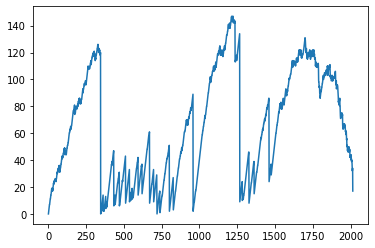

In [729]:
plt.plot(n_active)

In [701]:
# APPLY SORTING AND CREATE GEODATAFRAME
sorted_shape_ids = []
active_shape_ids = []
n_active=[]

# loop through pre-sorted shapes and add them to final sorting
# active shapes are all shapes that still overlap in x with current shape 
for i, id in enumerate(footprint_ids):
    left_x, left_y = left_x_dict[id], left_y_dict[id]

    # if they touch at rightmost point and both points have same y value, then there is no sorting among the shapes.  
    active_shape_ids = [a_id for a_id in active_shape_ids if right_x_dict[a_id] > left_x or (right_x_dict[a_id] == left_x and right_y_dict[a_id] != left_y)]
    n_active.append(len(active_shape_ids))
    
    if len(active_shape_ids)>0:
        pos, after = insertIntoOrder(shape_dict[id], active_shape_ids, pos_max=len(active_shape_ids)-1)
        sorted_shape_ids.insert(sorted_shape_ids.index(active_shape_ids[pos])+after, id)
        active_shape_ids.insert(pos+after, id)
    else: 
        sorted_shape_ids.append(id)
        active_shape_ids.append(id)

# create dict for faster rank lookup
shape_rank_dict = dict([(id, i) for i,id in enumerate(sorted_shape_ids)])
bounded_from_dict = dict([(x['self_id'], x['bounded_from']) for x in footprints])

# APPLY SORTING
shape_arr.sort(key=lambda s: \
    (s['role'] == 'footprint', 
    shape_rank_dict[s['footprint_id']], 
    s['role']=='wall', 
    s['min_offset'] if s['role']=='wall' else 0), reverse=True)

# CREATE GDF
# Future improvements
# Performance: merge footprint and roofs as long as there is no other geometry inbetween
# move all walls as far down as possible
poly_gdf = GeoDataFrame({
    'geom_type': [item for sublist in [['poly', 'edge'] for x in shape_arr] for item in sublist],
    'height': [item for sublist in [[x['height']]*2 for x in shape_arr] for item in sublist], 
    'role': [item for sublist in [[x['role']]*2 for x in shape_arr] for item in sublist],
    'light': [item for sublist in [[round(100-100*x['orientation']) if x['role']=='wall' else 10, 80] for x in shape_arr] for item in sublist],
    'g_id': [item for sublist in  [[x['g_id']]*2 for x in shape_arr] for item in sublist],
    'footprint_id': [item for sublist in  [[x['footprint_id']]*2 for x in shape_arr] for item in sublist],
    'self_id': [item for sublist in  [[x['self_id']]*2 for x in shape_arr] for item in sublist],
    'valid': [item for sublist in  [[x['valid'], x['valid'] and x['role']=='wall'] for x in shape_arr] for item in sublist],
    'shape_rank': [item for sublist in  [[shape_rank_dict[x['footprint_id']]]*2 for x in shape_arr] for item in sublist],
    'left_x': [item for sublist in  [[x['left_x'] if x['role']=='footprint' else None]*2 for x in shape_arr] for item in sublist],
    'intercept': [item for sublist in  [[x['intercept'] if x['role']=='footprint' else None]*2 for x in shape_arr] for item in sublist],
    'bounded_from': [item for sublist in  [[x['bounded_from'] if x['role']=='footprint' else None]*2 for x in shape_arr] for item in sublist]
    }, 
    geometry=[item for sublist in [[x['geometry'], x['geometry'].exterior.buffer(border_to_polygon_buffer, buff_resolution)] for x in shape_arr] for item in sublist], 
    crs=gdf_prep.crs
) 
poly_gdf = poly_gdf[poly_gdf['valid']]
# poly_gdf.head(5)


## Plot sorted gdf as 3 plot into 2D plane

In [720]:
# SET PLOT STYLE HERE
# 'YlOrBr'
fill_gaps_with_edges = True
edge_gap_fill_width = .35
dpi = 300
background_color = None#"#bbaadd"

general_style_attr = {
        'facecolor': {
            'value':'Reds',
            'value_col': 'shape_rank',
            'vmin': None-10,
            'vmax': 160,
            'alpha': 1,
            },
        'edgepoly_color': {
            'value':'black',
            'value_col': False,
            'alpha': 1,
            },
        'edgecolor': {
            'value':'None',
            'value_col': None,
            'alpha': 1,
            },
        'linewidth': {
            'value': 0,
            'value_col': False,
            },
        'alpha': { # alpha param can also be set on individual color attributes 
            'value': 1,
            'value_col': False,
            }
}

style_attr = {
    'footprint': {
        'facecolor': {
            'value': 'black',
            'value_col': False,
            'alpha': 1,
            },
        'edgepoly_color': {
            'value':None,
            'value_col': None,
            'alpha': None,
            },
        'edgecolor': {
            'value':None,
            'value_col': None,
            'alpha': None,
            },
        'linewidth': {
            'value': None,
            'value_col': None,
            },
        'alpha': {
            'value': 0,
            'value_col': None,
            }
    },
    'wall': {
        'facecolor': {
            'value': None,
            'value_col': None,
            'alpha': None,
            },
        'edgepoly_color': {
            'value':None,
            'value_col': None,
            'alpha': None,
            },
        'edgecolor': {
            'value':None,
            'value_col': None,
            'alpha': None,
            },
        'linewidth': {
            'value': None,
            'value_col': None,
            },
        'alpha': {
            'value': None,
            'value_col': None,
            }
    },
    'roof': {
        'facecolor': {
            'value': None,
            'value_col': None,
            'alpha': None,
            },
        'edgepoly_color': {
            'value':None,
            'value_col': None,
            'alpha': None,
            },
        'edgecolor': {
            'value':None,
            'value_col': None,
            'alpha': None,
            },
        'linewidth': {
            'value': None,
            'value_col': None,
            },
        'alpha': {
            'value': None,
            'value_col': None,
            }
    }
}


In [721]:
# overwrite role style attributes unless they are more specific
role_clr_dict = {}
color_attributes = ['facecolor', 'edgepoly_color', 'edgecolor']
roles = list(style_attr.keys())
gdf_cols = poly_gdf.columns

for role in roles:
    role_clr_dict[role] = {}
    for attr in style_attr[role].keys():
        val = style_attr[role][attr]['value']
        val_col = style_attr[role][attr]['value_col']
        
        share_col = (val_col == None) or (val_col == general_style_attr[attr]['value_col'])
        share_style = (val == None) or (val == general_style_attr[attr]['value'])
        share_scale = share_col # and share_style # add this option
        
        if val == None: val = general_style_attr[attr]['value']
        if val_col == None: val_col = general_style_attr[attr]['value_col']
        
        style_attr[role][attr]['value'] = val
        style_attr[role][attr]['value_col'] = val_col
        
        if not ('vmin' in list(style_attr[role][attr].keys())  and style_attr[role][attr]['vmin'] != None):
            if not ('vmin' in list(general_style_attr[attr].keys()) and general_style_attr[attr]['vmin'] != None):
                
                if val_col in gdf_cols:
                    style_attr[role][attr]['vmin'] = poly_gdf[val_col].min() if share_scale else poly_gdf[poly_gdf['role']==role][val_col].min()
                else:
                    style_attr[role][attr]['vmin'] = 0
            else:
                style_attr[role][attr]['vmin'] = general_style_attr[attr]['vmin']
        
        
        if not ('vmax' in list(style_attr[role][attr].keys())  and style_attr[role][attr]['vmax'] != None):
            if not ('vmax' in list(general_style_attr[attr].keys()) and general_style_attr[attr]['vmax'] != None):
                
                if val_col in gdf_cols:
                    style_attr[role][attr]['vmax'] = poly_gdf[val_col].max() if share_scale else poly_gdf[poly_gdf['role']==role][val_col].max()
                else:
                    style_attr[role][attr]['vmax'] = 1
            else:
                style_attr[role][attr]['vmax'] = general_style_attr[attr]['vmax']
    
            
        
        if attr in color_attributes: 

            if style_attr[role][attr]['alpha'] == None:
                style_attr[role][attr]['alpha'] = general_style_attr[attr]['alpha']

            tp = 'cmap' if type(val) != str else 'cmap' if val in plt.colormaps() else 'color'
            style_attr[role][attr]['type'] = tp
            
            if tp != 'cmap':
                style_attr[role][attr]['value'] = val
            else:
                style_attr[role][attr]['value'] = plt.get_cmap(val, 100)
        
    if fill_gaps_with_edges and role in ['roof', 'footprint']: 
        style_attr[role]['edgecolor'] = style_attr[role]['facecolor']
        if style_attr[role]['edgecolor']['alpha'] == None:
            style_attr[role]['edgecolor']['alpha'] = style_attr[role]['alpha']['value'] \
                if style_attr[role]['alpha']['value'] != None else general_style_attr['alpha']['value'] \
                if general_style_attr['alpha']['value'] != None else 1
        if style_attr[role]['linewidth']['value'] == 0:
            style_attr[role]['linewidth']['value'] = edge_gap_fill_width

# remove all non visible geometries from dataframe to improve plotting time
roles_to_plot = [role for role in roles \
    if style_attr[role]['alpha']['value'] not in [0, None] and any([style_attr[role][attr]['value'] not in ['None', None] for attr in color_attributes])]
if len(roles_to_plot)==len(roles):
    plot_gdf = poly_gdf
else:
    plot_gdf = poly_gdf[[role in roles_to_plot for role in poly_gdf['role']]]

if not any([style_attr[role]['edgepoly_color']['value'] not in ['None', None] for role in roles_to_plot]):
    plot_gdf = plot_gdf[plot_gdf['geom_type'] != 'edge']


In [722]:
style_attr

{'footprint': {'facecolor': {'value': 'black',
   'value_col': False,
   'alpha': 1,
   'vmin': 0,
   'vmax': 1,
   'type': 'color'},
  'edgepoly_color': {'value': 'black',
   'value_col': False,
   'alpha': 1,
   'vmin': 0,
   'vmax': 1,
   'type': 'color'},
  'edgecolor': {'value': 'black',
   'value_col': False,
   'alpha': 1,
   'vmin': 0,
   'vmax': 1,
   'type': 'color'},
  'linewidth': {'value': 0.35, 'value_col': False, 'vmin': 0, 'vmax': 1},
  'alpha': {'value': 0, 'value_col': False, 'vmin': 0, 'vmax': 1}},
 'wall': {'facecolor': {'value': <matplotlib.colors.LinearSegmentedColormap at 0x21e7209fa90>,
   'value_col': 'shape_rank',
   'alpha': 1,
   'vmin': 0,
   'vmax': 2015,
   'type': 'cmap'},
  'edgepoly_color': {'value': 'black',
   'value_col': False,
   'alpha': 1,
   'vmin': 0,
   'vmax': 1,
   'type': 'color'},
  'edgecolor': {'value': 'None',
   'value_col': None,
   'alpha': 1,
   'vmin': 0,
   'vmax': 1,
   'type': 'color'},
  'linewidth': {'value': 0, 'value_col': 

In [723]:
# COMPILE ARGUMENTS FOR PLOT
args = {}
attr_role_value_col_dict = dict([(attr, dict([(role, style_attr[role][attr]['value_col']) for role in roles])) for attr in general_style_attr.keys()])
role_pos_dict = dict([(role, roles.index(role)) for role in roles])

# ADD FACECOLOR AND COLOR POLYGON EDGES
role_value_col_dict = attr_role_value_col_dict['facecolor']
colors.to_rgba("#fffb")
args['facecolor'] = \
    np.array([\
        (style_attr[role][attr]['value'](\
            round(\
                100*(val_cols[role_pos_dict[role]]-style_attr[role][attr]['vmin'])/(style_attr[role][attr]['vmax']-style_attr[role][attr]['vmin'])\
            )\
        ) \
        if style_attr[role][attr]['type']=='cmap' else \
        colors.to_rgba(style_attr[role][attr]['value']))[:3] + \
        (style_attr[role][attr]['alpha'],)    \
        for role, attr, val_cols in zip(\
            plot_gdf['role'], 
            ['facecolor' if geom_type == 'poly' else 'edgepoly_color' for geom_type in plot_gdf['geom_type']], 
            zip(*[plot_gdf[val_col] if val_col in plot_gdf.columns else range(len(plot_gdf)) for val_col in [role_value_col_dict[role] for role in roles]]),
        )], dtype=object)

# ADD EDGECOLOR
attr = 'edgecolor'
role_value_col_dict = attr_role_value_col_dict[attr]
args[attr] = \
    np.array([\
        (0,0,0,0) if geom_type == 'edge' else
        (style_attr[role][attr]['value'](\
            round(\
                100*(val_cols[role_pos_dict[role]]-style_attr[role][attr]['vmin'])/(style_attr[role][attr]['vmax']-style_attr[role][attr]['vmin'])\
            )\
        ) \
        if style_attr[role][attr]['type']=='cmap' else \
        colors.to_rgba(style_attr[role][attr]['value']))[:3] + \
        (style_attr[role][attr]['alpha'],)    \
        for role, geom_type, val_cols in zip(\
            plot_gdf['role'], 
            plot_gdf['geom_type'], 
            zip(*[plot_gdf[val_col] if val_col in gdf_cols else range(len(plot_gdf)) for val_col in [role_value_col_dict[role] for role in roles]]),
        )], dtype=object)

# ADD LINEWIDTH
attr = 'linewidth'
role_value_col_dict = attr_role_value_col_dict[attr]
args[attr] = \
    np.array([\
        0 if geom_type == 'edge' else \
        round(\
            100*(val_cols[role_pos_dict[role]]-style_attr[role][attr]['vmin'])/(style_attr[role][attr]['vmax']-style_attr[role][attr]['vmin'])\
        )*style_attr[role][attr]['value']\
        if style_attr[role][attr]['value_col'] in gdf_cols else \
        style_attr[role][attr]['value'] \
        for role, geom_type, val_cols in zip(\
            plot_gdf['role'], 
            plot_gdf['geom_type'], 
            zip(*[plot_gdf[val_col] if val_col in gdf_cols else range(len(plot_gdf)) for val_col in [role_value_col_dict[role] for role in roles]]),
        )])


# ADD ALPHA
attr = 'alpha'
role_value_col_dict = attr_role_value_col_dict[attr]
args[attr] = \
    np.array([\
        round(\
            100*(val_cols[role_pos_dict[role]]-style_attr[role][attr]['vmin'])/(style_attr[role][attr]['vmax']-style_attr[role][attr]['vmin'])\
        )*style_attr[role][attr]['value']\
        if style_attr[role][attr]['value_col'] in gdf_cols else \
        style_attr[role][attr]['value'] \
        for role, val_cols in zip(\
            plot_gdf['role'],
            zip(*[plot_gdf[val_col] if val_col in gdf_cols else range(len(plot_gdf)) for val_col in [role_value_col_dict[role] for role in roles]]),
        )])

In [724]:
args

{'facecolor': array([[0.403921568627451, 0.0, 0.05098039215686274, 1],
        [0.0, 0.0, 0.0, 1],
        [0.403921568627451, 0.0, 0.05098039215686274, 1],
        ...,
        [1.0, 0.9607843137254902, 0.9411764705882353, 1],
        [0.0, 0.0, 0.0, 1],
        [1.0, 0.9607843137254902, 0.9411764705882353, 1]], dtype=object),
 'edgecolor': array([[0.0, 0.0, 0.0, 1],
        [0, 0, 0, 0],
        [0.0, 0.0, 0.0, 1],
        ...,
        [0.0, 0.0, 0.0, 1],
        [0, 0, 0, 0],
        [1.0, 0.9607843137254902, 0.9411764705882353, 1]], dtype=object),
 'linewidth': array([0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.35]),
 'alpha': array([1, 1, 1, ..., 1, 1, 1])}

In [725]:
# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20))
# rs = poly_gdf[poly_gdf['role']=='footprint']
# rs.plot(ax=ax, column='shape_rank', cmap='Reds', linewidth=.3, edgecolor='black')#, edgecolor='black', linewidth=10/len(gdf_prep)
# for (x, y), label in zip([g.centroid.coords[0] for g in rs['geometry']], [str(x) for x in rs['shape_rank']]):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# # for (x, y), label in zip([g.centroid.coords[0] for g in rs['geometry']], [str(x) for x in rs['footprint_id']]):
# #     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# # ax.set_xlim(13.4013, 13.40331)
# # ax.set_ylim(52.53485, 52.535)

In [726]:
# rs_id = list(rs['self_id'][[x in [5,6] for x in rs['shape_rank']]])

In [727]:
# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20))
# rs = poly_gdf[poly_gdf['role']=='footprint']
# rs.plot(ax=ax, column='bounded_from', cmap='Reds', linewidth=.3, edgecolor='black', alpha=.7)#, edgecolor='black', linewidth=10/len(gdf_prep)
# for (x, y), label in zip([g.centroid.coords[0] for g in rs['geometry']], [str(x) for x in rs['shape_rank']]):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# GeoSeries([rs.iloc[2].geometry]).plot(ax=ax, color='blue')

0

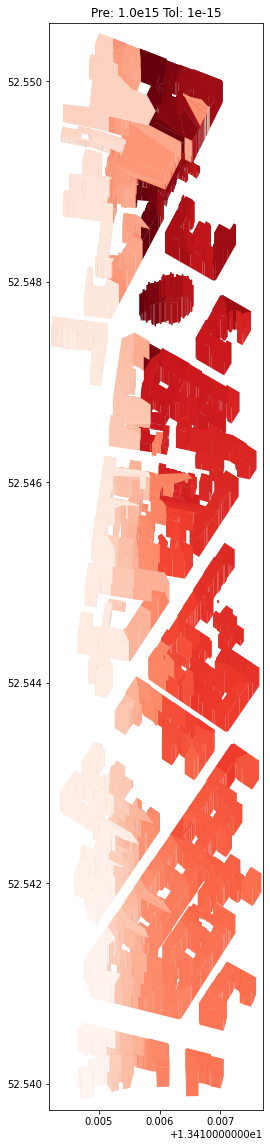

In [728]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20))
b = plot_gdf.total_bounds
x_padding, y_padding = (b[2]-b[0])/100, (b[3]-b[1])/100

if background_color:
    padding_box = Polygon([(b[0]-x_padding, b[1]-y_padding), (b[2]+x_padding, b[1]-y_padding), (b[2]+x_padding, b[3]+y_padding), (b[0]-x_padding, b[3]+y_padding)])
    GeoSeries([padding_box]).plot(ax=ax, color=background_color, alpha=.2)
plot_gdf.plot(ax=ax, **args)

ax.set_xlim(b[0]-x_padding, b[2]+x_padding)
ax.set_ylim(b[1]-y_padding, b[3]+y_padding)
ax.set_title("Pre: "+str(precision_fix/(10**math.ceil(math.log10(precision_fix))))+'e'+str(int(math.log10(precision_fix)))+" Tol: "+str(precision_tolerance))

filename = ('./plots/3D_map_neut_'+str(datetime.now())[0:13]+'.png').replace(" ", "_")
plt.savefig(filename, dpi=dpi)
os.system('start '+filename)
